# WGS Mapping to Variant Calls - Version 1.0

Implementing one of the [`samtools` Workflows](http://www.htslib.org/workflow/#mapping_to_variant) in [SoS](https://github.com/vatlab/SOS). Some steps were re-implemented using `GATK4` instead of `GATK3` / `Pichard` or `samtools`, for better performance.

**Multithreading: since GATK4 the multi-thread option `-nct` is not available. One has to use Spark version to achieve it**

In [1]:
%revisions -s -n 10

Revision,Author,Date,Message
924d9ab,Gao Wang,2018-10-14,Add docker image tags to workflow examples
c70ac44,Gao Wang,2018-09-04,Add a check for index files
1ea76f2,Gao Wang,2018-09-04,Set zap to True by default
b98d99e,Gao Wang,2018-09-03,Update docker option
3bf8f4d,Gao Wang,2018-09-03,Add a step to select given list of variants
33fd12c,Gao Wang,2018-09-03,Get toy example to work
8f3b701,Gao Wang,2018-09-03,Add links to toy reference data


## Overview

This SoS workflow notebook contains three workflows:

- `get_ref_genome` which downloads reference genome data, in preparation for genotype calling
- `get_known_variants` which downloads known variants data, in preparation of genotype calling
- `default`, a sequence of commands to perform multi-sample genotype calling for given list of samples

All workflow steps are numerically ordered to reflect the execution logic. This is the most straightforward SoS workflow style, the "process-oriented" style. 

To view available workflows and options,

In [2]:
!sos run WGS_Call.ipynb -h

usage: sos run WGS_Call.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  get_ref_genome
  get_known_variants
  

Global Workflow Options:
  --samples . (as path)
                        a file containing sample names
  --wd WGS_Call_SoS (as path)
                        work directory
  --ref-genome  path(f'{wd:a}/ref/reference.fa')

                        name of reference genome file
  --ref-variants  path(f'{wd:a}/ref/known_variants.vcf.gz')

                        name of known variant sites file
  --ref-indel  path(f'{wd:a}/ref/known_variants.vcf.gz')

                        name of known indel file
  --genome-url 'https://github.com/vatlab/sos-docs/raw/master/src/example

## Input data

Input in `fastq` format, paired-ended:

```
Sample_75641_2.fq.gz Sample_75641_2.fq.gz
```

## Reference data preparation

To prepare reference genome data, run:

```
sos run WGS_Call.ipynb get_ref_genome
```

To prepare reference known variants data, run:

```
sos run WGS_Call.ipynb get_known_variants
```

These commands will download reference data to `./WGS_Call_SoS/ref` 
(work directory, can be configured via `--wd` option as shown in the workflow help message above). 

If you already have reference genome data bundle and known variants data you can use `--ref-genome`, 
`--ref-variants` and `--ref-indel` to specify them. Otherwise you should edit `get_ref_genome` and `get_known_variants`
steps below to download them. The default is pointed to a toy example data-set for demonstration

## Run the workflow

The workflow has been tested on Linux and Mac. 
In brief, after installing [SoS](https://github.com/vatlab/SOS) (see "Software Configuration" below), 
you provide a text file of sample list named eg `k9-test/test_samples.manifest`, with contents:

```
Sample_79162
Sample_75641
```

Under the same folder as this list file, you keep all the listed sample `fastq` files. Then you run

```
sos run WGS_Call.ipynb --samples k9-test/test_samples.manifest -j2
```

to perform variant calling. `-j2` option means to run 2 processes in parallel. 
After it completes you'll find under folder `./WGS_Call_SoS` (can be configured):

1. `WGS_Call.html` of this document
2. `bam` folder of intermediate and processed BAM files. Only BAM files from the last preprocessing step is kept by default, unless option `--no-zap` (which changes `parameter: zap = ...` in the workflow) is appended to the command above.
3. `vcf` folder of genotype call. The final output is `vcf/test_samples.filtered.vcf.gz` -- the file name is derived after your input sample list `/path/to/this/test_samples.manifest`


You can also "dryrun" the workflow to see what is actually going on:

```
sos dryrun WGS_Call.ipynb --samples k9-test/test_samples.manifest
```

Or, run / dryrun a few steps, eg, the first 5 steps.

```
sos dryrun WGS_Call.ipynb default:1-5 --samples k9-test/test_samples.manifest
```

`dryrun` will print out all commands which you can collect to a file and run them separately (for debugging, for example).

### Do we keep all loci even if they are not variants?

Yes we do (for obvious reasons)! This is why `--variants_only` is `False` by default. However it is a huge file to work on. We include an option `--keep_coord` that provides a list of genomic coordinates like this:

```
1	2815013
1	7421527
1	11653215
1	12326997
1	14892273
1	16663755
```

This case, only selected loci (variants of interest) are kept for further investigation.

## Software configuration

To install SoS, make sure you have Python 3.6, then:

```
pip install -U sos sos-notebook sos-pbs
python -m sos_notebook.install
```

To open the notebook:

```
jupyter notebook WGS_Call.ipynb &> /dev/null &
```

If you do not already have `sos_notebook` on your computer, you will need to close this notebook after installation and open it again to see the `sos_notebook` kernel take effect in your Juptyer.

To better display notebook edits from `git`:

```
pip install nbdime
nbdime config-git --enable --global
```

Finally you need to install and configure `docker`:

1. Run commands below:
```
curl -fsSL get.docker.com -o get-docker.sh
sudo sh get-docker.sh
sudo usermod -aG docker $USER
```
2. Log out and log back in (no need to reboot computer)

## Global parameter settings

In [3]:
[global]
# a file containing sample names
parameter: samples = path() 
# work directory
parameter: wd = path('./WGS_Call_SoS')
# name of reference genome file
parameter: ref_genome = path(f'{wd:a}/ref/reference.fa')
# name of known variant sites file
parameter: ref_variants = path(f'{wd:a}/ref/known_variants.vcf.gz')
# name of known indel file
parameter: ref_indel = path(f'{wd:a}/ref/known_variants.vcf.gz')
# download link for reference fasta file, in gz format
parameter: genome_url = "https://github.com/vatlab/sos-docs/raw/master/src/examples/k9-test/reference.fa.gz"
# download link for known variants vcf file, in gz format
parameter: variants_url = "https://github.com/vatlab/sos-docs/raw/master/src/examples/k9-test/known.vcf.gz"
# whether or not to remove files from intermediate steps
parameter: zap = True
# bcftools default quality filter
parameter: bcftools_filter = '%QUAL>10'
# number of CPU threads to use per process
parameter: ncpu = 3
# can be empty, or chr, or Chr depending on input data-set.
parameter: chr_prefix = 'chr'
# Human is 23, Bovine is 29, Canine is 38; 
# we focus on autosome and X.
parameter: n_chrom = 38
chroms = ' '.join([f'{chr_prefix}{x+1}' for x in range(n_chrom)] + [f'{chr_prefix}X'])
# Set to True to only call variant sites not "wildtype"
parameter: variants_only = False
# Keep a list of specified variants only
parameter: keep_coord = path()

## Reference preparation
 
### Reference genome

Use primary assembly sequence. See [this post](https://bioinformatics.stackexchange.com/questions/540/what-ensembl-genome-version-should-i-use-for-alignments-e-g-toplevel-fa-vs-p?rq=1) for details.

In [4]:
# Download reference genome
[get_ref_genome_1]
output: ref_genome
download: dest_file = f'{_output}.gz', expand = True
    {genome_url}
bash: container='gaow/debian-ngs:1.0', volumes=[f'{wd:a}:{wd:a}'], expand = True
    gunzip -f {ref_genome}.gz

create reference index and dict files

In [5]:
# Index reference genome
[get_ref_genome_2]
depends: system_resource(mem = '4G')
output: f'{ref_genome:n}.dict', f'{ref_genome}.fai', f'{ref_genome}.bwt',
        f'{ref_genome}.pac', f'{ref_genome}.ann', f'{ref_genome}.amb', f'{ref_genome}.sa'
stop_if(all([path(x).is_file() for x in _output]))
run: container='gaow/debian-ngs-gatk4:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{ref_genome}.err', stdout=f'{ref_genome}.out'
    rm -f {_output}
    samtools faidx {_input} && \
    bwa index {_input} && \
    gatk CreateSequenceDictionary -R {_input} -O {_output[0]}

### Known sites

[NCBI dbSNP](ftp://ftp.ncbi.nih.gov/snp/organisms/archive) has reference SNP files for various species.

In [6]:
# Download known variants
[get_known_variants_1]
output: f'{ref_variants:nn}.unsorted.vcf.gz'
download: dest_file = f'{_output}', expand = True
    {variants_url}

Sort and index VCF

In [7]:
# Index known variants
[get_known_variants_2]
depends: system_resource(mem = '4G')
output: ref_variants
bash: container='gaow/debian-ngs-gatk4:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    gatk SortVcf -I {_input} -O {_output} \
        --SEQUENCE_DICTIONARY {ref_genome:n}.dict \
        --COMPRESSION_LEVEL 9 && \
    gatk IndexFeatureFile -F {_output}
if zap:
    _input.zap()

The standard workflow for working with DNA sequence data consists of three major steps:

- Mapping
- Improvement
- Variant Calling

In [8]:
# Export workflow to HTML file
[0]
input: [item for item in sys.argv if item.endswith('.ipynb')], group_by = 1, pattern = '{fn}.ipynb'
output: expand_pattern(f'{wd:a}/{path(_fn[0]):b}.html')
bash: expand=True, stderr=False
  sos convert {_input} {_output}

## Mapping

We skip the `bwa` steps because our data has already been mapped. 

Because BWA can sometimes leave unusual FLAG information on SAM records, it is helpful when working with many tools to first clean up read pairing information and flags.

In [9]:
# BWA mapping & samtools postprocessing
[1]
depends: system_resource(mem = '4G')
fail_if(not samples.is_file(), msg = 'Need sample name list file!')
sample_files = list(set(get_output(f"awk '{{print $1}}' {samples:e}").strip().split('\n')))
fail_if(len(sample_files) == 0, msg = 'Need input sample files!')
input: [(f'{samples:d}/{x}_1.fq.gz', f'{samples:d}/{x}_2.fq.gz') for x in sample_files], group_by = 2
output: f'{wd:a}/{samples:bn}_bam/{_input[0]:bnn}.fixmate.bam'
run: container='gaow/debian-ngs:1.0', volumes=[f'{samples:da}:{samples:da}', f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    bwa mem -t {ncpu} -M -R "@RG\\tID:{os.path.basename(sample_files[_index].replace('-', '_'))}\\tSM:{os.path.basename(sample_files[_index].replace('-', '_'))}\\tLB:library1\\tPL:ILLUMINA\\tPU:{os.path.basename(sample_files[_index].replace('-', '_'))}.library1" {ref_genome} {_input[0]} {_input[1]} | samtools sort -n - | samtools fixmate -O bam - {_output}

To sort them from name order into coordinate order,

In [10]:
# Sort BAM files
[2]
# sort via GATK4 is way faster
# https://software.broadinstitute.org/gatk/blog?id=9644
output: f'{_input:n}.sorted.bam'
run: container='gaow/debian-ngs-gatk4:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    gatk SortSam -I {_input} -O {_output} -SO coordinate
if zap:
    _input.zap()

We extract relevant chromosomes and re-order to match ordering in reference,

In [11]:
# Extract relevant chromosomes for analysis
[3]
output: f'{_input:n}.cleaned.bam'
run: container='gaow/debian-ngs-gatk4:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    samtools index {_input}
    samtools view -@ {ncpu} -b {_input} {chroms} > {_output}
if zap:
    _input.zap()

In [12]:
# Re-order bam files
[4]
output: f'{_input:n}.reordered.bam'
run: container='gaow/debian-ngs-gatk4:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    gatk ReorderSam -I {_input} -O {_output} -R {ref_genome} \
        --CREATE_INDEX TRUE \
        --ALLOW_INCOMPLETE_DICT_CONCORDANCE TRUE
if zap:
    _input.zap()

## Improvement

In order to reduce the number of miscalls of INDELs in your data it is helpful to realign your raw gapped alignment with the Broad’s GATK3 Realigner. This is necessary only when used with other genotype callers. In GATK4 best practice pipeline this step can be skipped if HaplotypeCaller is used.

Note: option `-nct` does not apply to `RealignerTargetCreator` and `IndelRealigner`.

In [13]:
# Indel re-alignment
[5]
output: f'{_input:n}.realigned.bam'
run: container='gaow/gatk3:2.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    java -jar /opt/GenomeAnalysisTK.jar -T RealignerTargetCreator \
        -R {ref_genome} \
        -I {_input} \
        -o {_input:n}.intervals \
        --known {ref_indel} && \
    java -jar /opt/GenomeAnalysisTK.jar -T IndelRealigner \
        -R {ref_genome} \
        -I {_input} \
        -targetIntervals {_input:n}.intervals \
        -known {ref_indel} \
        -o {_output}
if zap:
    _input.zap()

BQSR from the Broad’s GATK allows you to reduce the effects of analysis artefacts produced by your sequencing machines. It does this in two steps, the first analyses your data to detect covariates and the second compensates for those covariates by adjusting quality scores.

In [14]:
# Base recalibration
[6]
output: f'{_input:n}.recal.bam'
run: container='gaow/debian-ngs-gatk4:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output}.err', stdout=f'{_output}.out'
    gatk BaseRecalibrator \
        -R {ref_genome} \
        --known-sites {ref_variants} \
        -I {_input} -O {_input:n}.table && \
    gatk ApplyBQSR -I {_input} -bqsr {_input:n}.table -O {_output} # --create-output-bam-index TRUE
if zap:
    _input.zap()

It is helpful at this point to compile all of the reads from each library together into one BAM, which can be done at the same time as marking PCR and optical duplicates. To identify duplicates we currently recommend the use of either the Picard or biobambam’s mark duplicates tool.

*The following step only Marks duplicates instead of removing duplicates*

In [15]:
# Mark duplicates
[7]
output: f'{_input:n}.dedup.bam'
run: container='gaow/debian-ngs-gatk4:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    gatk MarkDuplicates \
        --VALIDATION_STRINGENCY LENIENT \
        --INPUT {_input} --OUTPUT {_output} \
        --METRICS_FILE {_output:n}.metrics_file \
        --CREATE_INDEX TRUE
if zap:
    _input.zap()

It is possible to view summary of BAM files in SoS, using `%preview` feature, for example,

In [16]:
%preview WGS_Call_SoS/test_samples_bam/Sample_75641_1.fixmate.sorted.cleaned.reordered.realigned.recal.dedup.bam

%preview WGS_Call_SoS/test_samples_bam/Sample_75641_1.fixmate.sorted.cleaned.reordered.realigned.recal.dedup.bam

> WGS_Call_SoS/test_samples_bam/Sample_75641_1.fixmate.sorted.cleaned.reordered.realigned.recal.dedup.bam (335.6 KiB):

RG:
  ID: 'Sample_75641'    SM: 'Sample_75641'    LB: 'library1'    PL: 'ILLUMINA'    ...
PG:
  ID: 'bwa'    PN: 'bwa'    VN: '0.7.15-r1140'    CL: bwa mem -t 3 -M -R @RG\tID:Sample_75641\tSM:Sample_75641\tLB...Sample_75641_2.fq.gz    
  ID: 'GATK IndelRealigner'    VN: '3.8-1-0-gf15c1c3ef'    CL: knownAlleles=[(RodBinding name=knownAlleles source=/home/gao...ileForDebugging=null    
  ID: 'GATK ApplyBQSR'    VN: '4.0.3.0'    CL: ApplyBQSR  --output /home/gaow/Documents/GIT/wiki/sos-docs/s...se	PN:GATK ApplyBQSR    
  ID: 'MarkDuplicates'    VN: 'Version:4.0.3.0'    CL: MarkDuplicates  --INPUT /home/gaow/Documents/GIT/wiki/sos-do...se	PN:MarkDuplicates    
SQ:
  SN: 'chr36'    LN: 30001    M5: '68869954ee006c7821633a97b0a62430'    UR: file:/home/gaow/Documents/GIT/wiki/sos-docs/src/examples/WGS...SoS/ref/reference.fa    
  SN: 'chr37'    LN: 30001    M5: 'af868c903d4fa5e8484cff65c55a6368'    UR: file:/home/gaow/Documents/GIT/wiki/sos-docs/src/examples/WGS...SoS/ref/reference.fa    
  S

## Variant Calling
To convert your BAM file into genomic positions we first use mpileup to produce a BCF file that contains all of the locations in the genome. We use this information to call genotypes and reduce our list of sites to those found to be variant by passing this file into bcftools call.

In [17]:
# Multi-sample variant calling -- pileup
[8]
# the 2nd line can have many samples separated by space
input: group_by = 'all'
output: f'{wd:a}/{samples:bn}_vcf/{samples:bn}.bcf'
run: container='gaow/debian-ngs:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    bcftools mpileup -Ob -f {ref_genome} --threads {ncpu} -o {_output} {_input}

In [18]:
# Multi-sample variant calling -- call
[9]
output: f'{_input:n}.vcf.gz'
run: container='gaow/debian-ngs:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    bcftools call -{"v" if variants_only else ""}mO z --threads {ncpu} -o {_output} {_input} \
    && tabix -p vcf {_output}

Additionally you may find it helpful to prepare graphs and statistics to assist you in filtering your variants:

In [19]:
# Quality summary plots for VCF file
[10]
output: f'{_input:n}.stats'
run: container='gaow/debian-ngs-gatk4:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    bcftools stats -F {ref_genome} -s - {_input} > {_output}
    mkdir -p {_input:nn}_plots
    plot-vcfstats -P -p {_input:nn}_plots {_output}

To view one of the summary plot in SoS,

%preview WGS_Call_SoS/test_samples_vcf/test_samples_plots/substitutions.0.pdf

> WGS_Call_SoS/test_samples_vcf/test_samples_plots/substitutions.0.pdf (9.8 KiB):

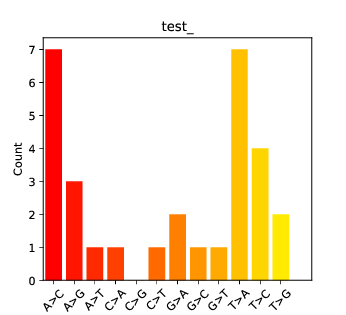

In [20]:
%preview WGS_Call_SoS/test_samples_vcf/test_samples_plots/substitutions.0.pdf -s png --dpi 80

Finally you will probably need to filter your data using commands such as:

In [21]:
# Quality filtering
[11]
output: f'{_input:nn}.filtered.vcf.gz'
run: container='gaow/debian-ngs:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    bcftools filter -O z -o {_output} \
        -s LOWQUAL -i'{bcftools_filter}' {_input:nn}.vcf.gz \
    && tabix -p vcf {_output}

Variant filtration is a subject worthy of an article in itself and the exact filters you will need to use will depend on the purpose of your study and quality and depth of the data used to call the variants.

In [22]:
# Only extract regions we are interested in
[12]
stop_if(not keep_coord.is_file(), msg = 'Skip extracting selected SNPs because no list (--keep_coord coord.list) was provided to extract from.')
output: f'{_input:nn}.extracted.vcf.gz'
run: container='gaow/debian-ngs:1.0', volumes=[f'{wd:a}:{wd:a}'], expand=True, stderr=f'{_output:n}.err', stdout=f'{_output:n}.out'
    tabix -H {_input} > {_output:n}
    tabix {_input} -R {keep_coord} >> {_output:n}
    bgzip {_output:n}

## References
- The 1000 Genomes Project Consortium - An Integrated map of genetic variation from 1092 human genomes Nature 491, 56–65 (01 November 2012) doi:10.1038/nature11632
- [GATK Best Practices](http://www.broadinstitute.org/gatk/guide/best-practices)